## Import packages

In [1]:
import CairoMakie: activate!, Figure, Axis, lines!, scatter!, lines, scatter, scatterlines!, density!, hist!,
hlines!, vlines!, axislegend, Legend, series, series!, Theme, set_theme!, cgrad, band!, xlims!, ylims!, barplot!,
hist
import StatsBase: sample, mean, min, mode, fit, Histogram, std
import NaNStatistics: nanmean, nanstd
import Roots: find_zero, fzero, newton, Newton

import Plots: palette
c=palette(:default); c = [palette(:tab10)[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
colblue=palette(:default)[1];
#c=palette(:tab10); c = [c[1]; c[3]; c[4];c[5]; c[2]; [c[i] for i in 6:length(c)]]; #reorder colors
activate!() #activates the Makie backend
set_theme!(Theme(
    palette  = (color = cgrad(c,length(c)),),
    Lines    = (cycle = [:color],), 
    band     = (cycle = [:color],),
    hlines   = (cycle = [:color],),
    vlines   = (cycle = [:color],),
    scatter  = (cycle = [:color],),
    scatterlines = (cycle = [:color],),
    series   = (cycle = [:color],),
    colormap = cgrad(:default), 
    ))

In [2]:
function DecisionTrajectory_xvt(T::Number, η::Number, ϵk::AbstractVector, L::Number, numSpins::Integer, IC::String,
        x_init::Number, r0::Number, timemax::Number, dLcrossed::Number)
    # T - temperature
    # η - inhibition
    # ϵk - array of biases per target
    # L - threshold
    # numSpins - number of spins in one group (per target)
    # IC - initial condition of the active spins
    # x0 - initial position
    # r0 - units of rate
    # timemax - maximum time of the simulation
    # dLcrossed - distance to cut if finish far away from the target

    ## Initialization
    k = length(ϵk); # number of targets
    Pk = [1; -1]; #directions to the targets (right and left); Needs an update if k>2
    Vfunc(Nk::AbstractVector) = k==2 ? sum(Nk .* Pk)/(numSpins*k) : error("k is not 2!"); # velocity of the system

    ## Initial conditions
    Nk_cur = IC=="ZERO" ? zeros(Int8, k) : (IC=="RAND" ? [rand(1:numSpins) for i = 1:k] : error("IC is not valid!")); #[N1, N2, N3] - VEC kx1 define the current distribution of active spins (ON)
    x = x_init; # current position of the system
    v = Vfunc(Nk_cur); # current velocity of the system
    t = 0.0; # current time of the system
    dtrand = 0.0;

    x_seq = Array{Float64, 1}(); # positions of the system
    v_seq = Array{Float64, 1}(); # velocities of the system
    t_seq = Array{Float64, 1}(); # time of the system

    push!(x_seq, x); # save the initial position of the system
    push!(v_seq, v); # save the initial velocity of the system
    push!(t_seq, t); # save the initial time of the system
    ## Simulation
    while (abs(x) <= L)  # && (t < timemax)

        # on/off rates
        dH = (k .* v .* Pk .- η .+ ϵk); #energy difference if one spin-flip occurs
        
        rk_on    = r0* (numSpins .- Nk_cur) ./ (1 .+ exp.( -dH/T )); # group 1...k: ++1
        rk_off   = r0* Nk_cur               ./ (1 .+ exp.(  dH/T )); # group 1...k: --1
        rates    = [rk_on; rk_off]; #array of rates for each target
        rate_tot = sum(rates); # total rate

        # choose a group to change and time interval
        rand_flip = 1 - rand(); # get a second random number

        # calculate next step: one spin flip occurs
        event = findfirst(rand_flip .<= cumsum(rates ./ rate_tot)); # find the event
        off_event = Int8(event > k); # determine the sign of the event: on=(ind<=k) or off=(ind>k)
        ind_event = event - k*off_event; # index of the event
        Nk_cur[ind_event] = Nk_cur[ind_event] + (-1)^off_event;

        # calculate the time interval
        rand_time = 1 - rand(); # get a random number for gillespie
        dtrand = (1/rate_tot) * log(1/rand_time); # calculate next time interval dt

        #update velocity and position according to the new spin distributions
        x += v * dtrand; # update the position of the system using previous velocity
        v = Vfunc(Nk_cur); # update the velocity of the system
        t += dtrand; # update the current time

        push!(x_seq, x); # save position 
        push!(v_seq, v); # save velocity
        push!(t_seq, t); # save time
    end

    #check if the motion finished too far from the threshold L
    ## try if false and see how the jrajectory looks like at low T
    if abs(x) - L > L*dLcrossed  #if false
        if sign(x) > 0
            x = L;
            dx = L - x_seq[end-1]; #> 0
        else
            x = -L;
            dx = -L - x_seq[end-1]; #<0
        end
        t += -dtrand + dx / v_seq[end-1];
        t_seq[end] = t;
        x_seq[end] = x;
    end

    return x_seq, v_seq, t_seq
end

DecisionTrajectory_xvt(T, η, ϵk, L, numSpins; IC="ZERO", x_init=0.0, r0=1.0, timemax=1e15, dLcrossed=1e-5) = 
DecisionTrajectory_xvt(T, η, ϵk, L, numSpins, IC, x_init, r0, timemax, dLcrossed)

DecisionTrajectory_xvt (generic function with 2 methods)

# Single Decision Trajectory

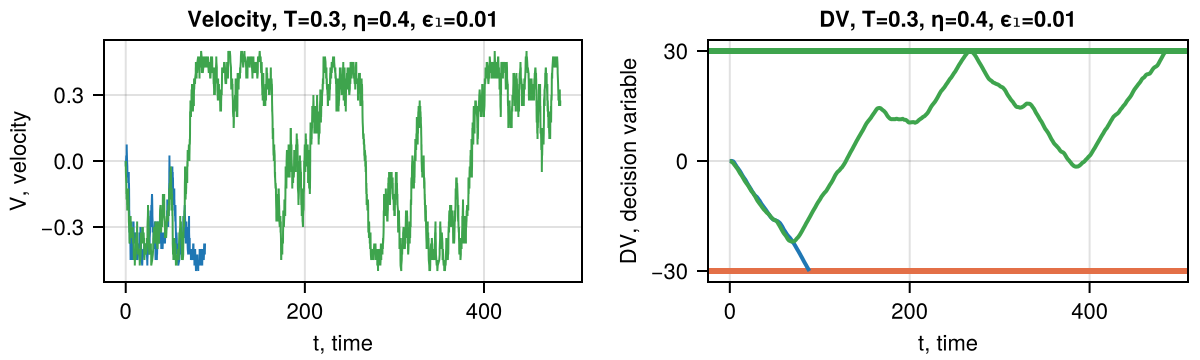

In [3]:
## parameter setup
L = 30; #threshold
numSpins = 20; #number of spins per group
dLcrossed = 1e-4; #distance to cut if finish far away from the target

T = 0.3; #temperature
η = 0.4; #inhibition
ϵ1 = 0.01; ϵk(ϵ1) = [ϵ1, 0]; #biases

## number of trajectories to show
iterations = 2;

fig = Figure(size=(600, 180), fontsize=11, figure_padding=(3, 6, 3, 3)); ax = []; #400, 300 
    push!(ax, Axis(fig[1,1], xlabel="t, time", ylabel="V, velocity", title="Velocity, T=$T, η=$η, ϵ₁=$ϵ1"));  
    push!(ax, Axis(fig[1,2], xlabel="t, time", ylabel="DV, decision variable", title="DV, T=$T, η=$η, ϵ₁=$ϵ1"));

    hlines!(ax[2], [ L], color=c[2], linewidth=3);
    hlines!(ax[2], [-L], color=c[3], linewidth=3);

for iter in 1:iterations
    x_vec, v_vec, t_vec = DecisionTrajectory_xvt(T, η, ϵk(ϵ1), L, numSpins, dLcrossed=dLcrossed);
    
    lines!(ax[1], t_vec, v_vec, linewidth=1);
    lines!(ax[2], t_vec, x_vec, linewidth=2);
end
ax[2].yticks = [-L, 0, L];
fig

# V distribution in multiple trajectories

In [ ]:
## parameter setup
L = 30; #threshold
numSpins = 20; #number of spins per group
dLcrossed = 1e-4; #distance to cut if finish far away from the target

T = 0.3; #temperature
η = 0.4; #inhibition
ϵ1 = 0.01; ϵk(ϵ1) = [ϵ1, 0]; #biases

iterations_vdist = 1000;  ## takes ~ 3s

all_vel = Array{Float64,1}();
for iter in 1:iterations_vdist
    x_vec, v_vec, t_vec = DecisionTrajectory_xvt(T, η, ϵk(ϵ1), L, numSpins); # get v(t) in each trajectory
    all_vel = [all_vel; v_vec];
end

## MF theory: prediction of the mean velocity
F(V) = V - 1/4*sinh((4*V + ϵ1)/(2*T)) / (cosh((2*V + η)/(2*T)) * cosh((2*V - η + ϵ1)/(2*T)));
vel_mean_field_pos = find_zero(F, 0.5);   vel_mean_field_neg = find_zero(F, -0.5);  

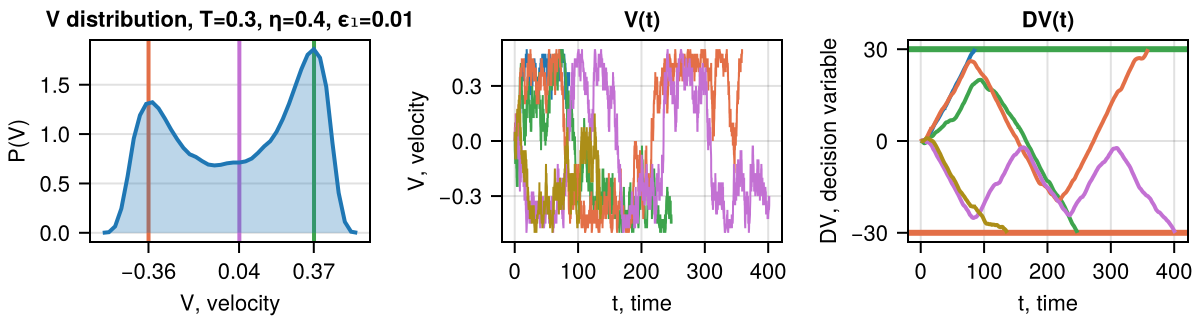

In [14]:
iterations_traj = 5; 

fig = Figure(size=(600, 160), fontsize=11, figure_padding=(3, 6, 3, 3));  ax = []; #400, 300 
    push!(ax, Axis(fig[1,1], xlabel="V, velocity", ylabel="P(V)", title="V distribution, T=$T, η=$η, ϵ₁=$ϵ1"));  
    push!(ax, Axis(fig[1,2], xlabel="t, time", ylabel="V, velocity", title="V(t)"));  
    push!(ax, Axis(fig[1,3], xlabel="t, time", ylabel="DV, decision variable", title="DV(t)"));

    hlines!(ax[3], [L, -L], color=[c[2], c[3]], linewidth=3);

for iter in 1:iterations_traj
    x_vec, v_vec, t_vec = DecisionTrajectory_xvt(T, η, ϵk(ϵ1), L, numSpins, dLcrossed=dLcrossed);
    lines!(ax[2], t_vec, v_vec, linewidth=1);
    lines!(ax[3], t_vec, x_vec, linewidth=2);
end

vlines!(ax[1], [vel_mean_field_pos, vel_mean_field_neg, mean(all_vel)], color=[c[2], c[3], c[4]], linewidth=2)
density!(ax[1], sort(all_vel), npoints = 42, color = (c[1], 0.3), strokecolor=c[1], strokewidth=2)
ax[1].xticks = round.([vel_mean_field_neg, vel_mean_field_pos, mean(all_vel)], digits=2)
ax[3].yticks = [-L, 0, L];
fig